[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/CompOmics/D012554A_2025/blob/main/notebooks/day_2/answers/2.1b_Exercises_Histone_marks_lr_answers.ipynb)

# 2.1 Exercises – Logistic Regression & Classification (Answers)

In the lecture notebook you applied logistic regression to classify gene expression levels from histone modification signals. In these exercises you will apply those same techniques to a new binary classification problem: diagnosing breast tumours as malignant or benign.

## Dataset: Breast Cancer Wisconsin (Diagnostic)

The dataset is computed from digitized images of fine needle aspirate (FNA) of breast masses. It contains 30 real-valued features describing cell nuclei:

| Feature group | Examples |
|---------------|----------|
| Mean values | `mean radius`, `mean texture`, `mean perimeter`, ... |
| Standard errors | `radius error`, `texture error`, ... |
| Worst (largest) values | `worst radius`, `worst texture`, ... |

The target is the diagnosis: `0 = malignant`, `1 = benign`.

Throughout these exercises you will:
1. Load and explore the data
2. Fit a baseline logistic regression model
3. Evaluate with accuracy and log-loss
4. Apply feature scaling and re-evaluate
5. Tune the regularisation hyperparameter `C` with cross-validation
6. Inspect feature importance from the model coefficients

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

random_seed = 123
np.random.seed(random_seed)

---
## Exercise 1 – Load and explore the dataset

Load the Breast Cancer dataset using `sklearn.datasets.load_breast_cancer()` and convert it to a Pandas DataFrame.

1. Print the shape of the feature matrix.
2. Display the first 5 rows.
3. Show the class distribution (how many malignant vs. benign?).

Hint: The returned object has `.data`, `.feature_names`, and `.target` attributes.

In [2]:
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()
features = pd.DataFrame(data.data, columns=data.feature_names)
target = pd.Series(data.target, name='target')

print(f"Feature matrix shape: {features.shape}")
print(f"\nFirst 5 rows:")
display(features.head())

print(f"\nClass distribution (0=malignant, 1=benign):")
print(target.value_counts())

Feature matrix shape: (569, 30)

First 5 rows:


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678



Class distribution (0=malignant, 1=benign):
target
1    357
0    212
Name: count, dtype: int64


---
## Exercise 2 – Visualize the features

1. Create a heatmap of a random sample of 20 rows (use `sns.heatmap`).
2. Create boxplots of all 30 features.

What do you notice about the scales of different features?

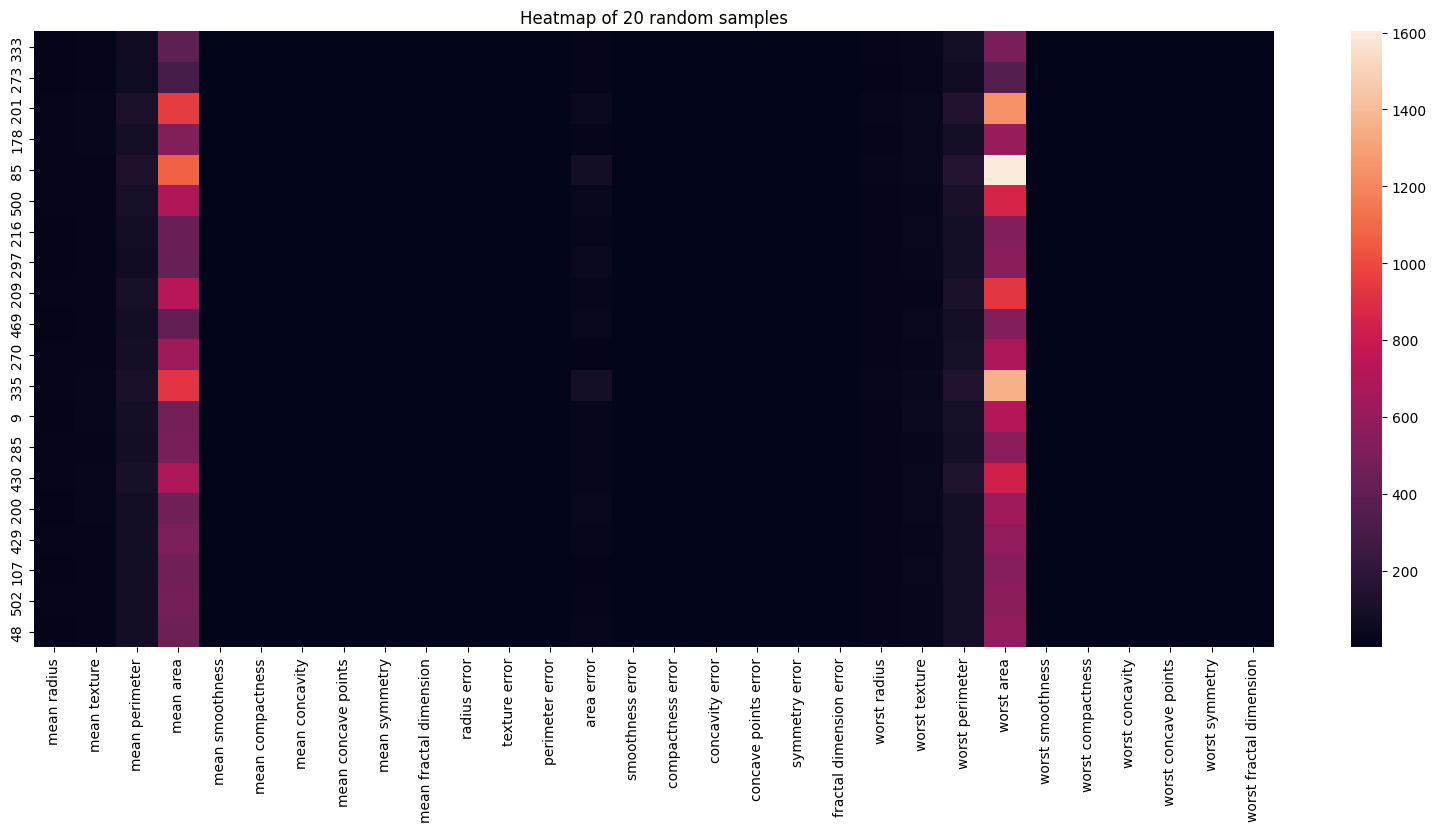

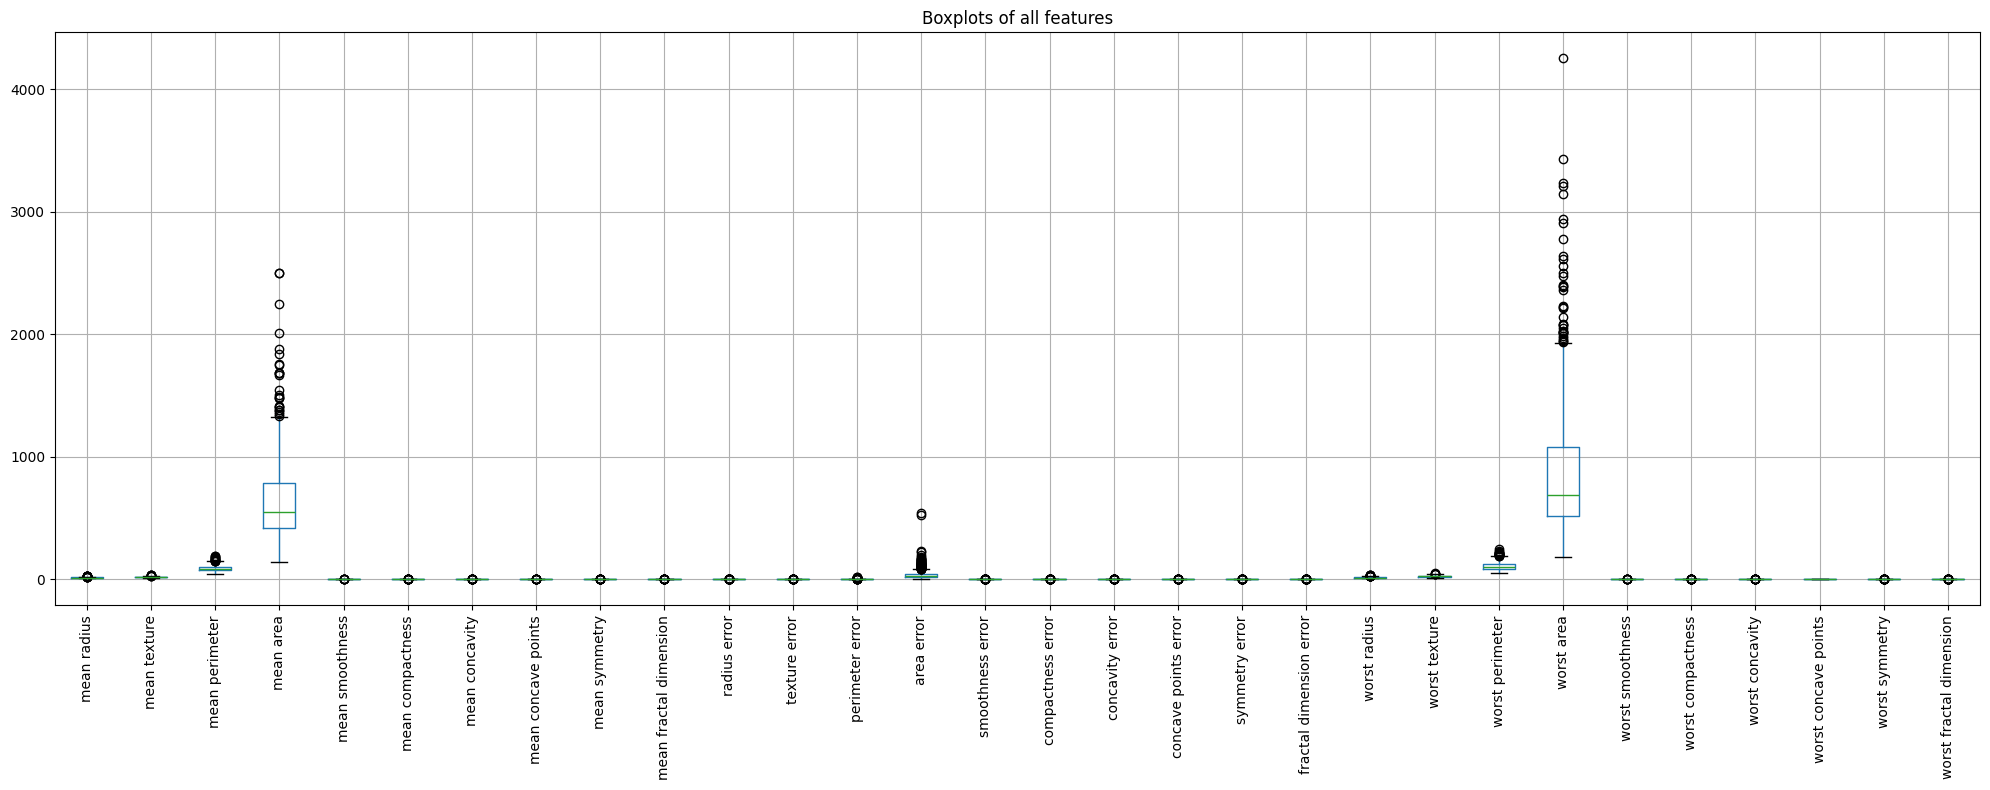

In [3]:
# Heatmap of 20 random samples
plt.figure(figsize=(20, 8))
sns.heatmap(features.sample(20, random_state=random_seed))
plt.title('Heatmap of 20 random samples')
plt.show()

# Boxplots of all features
plt.figure(figsize=(20, 8))
features.boxplot(rot=90)
plt.title('Boxplots of all features')
plt.tight_layout()
plt.show()

The features are at vastly different scales. For example, `mean area` and `worst area` have values in the hundreds/thousands, while `mean smoothness` has values near 0.1. This difference in scale means a few features dominate the heatmap and the boxplot, making it hard to see patterns in the smaller-valued features. Scaling will be essential before fitting the model.

---
## Exercise 3 – Boxplots grouped by feature type

The 30 features fall into three groups of 10 based on their suffix:
- mean features (e.g. `mean radius`)
- error features (e.g. `radius error`)
- worst features (e.g. `worst radius`)

Create separate boxplots for each group (3 plots total), similar to the lecture’s per-histone-mark boxplots.

Hint: Use a list comprehension to select columns containing `"mean"`, `"error"`, or `"worst"`.

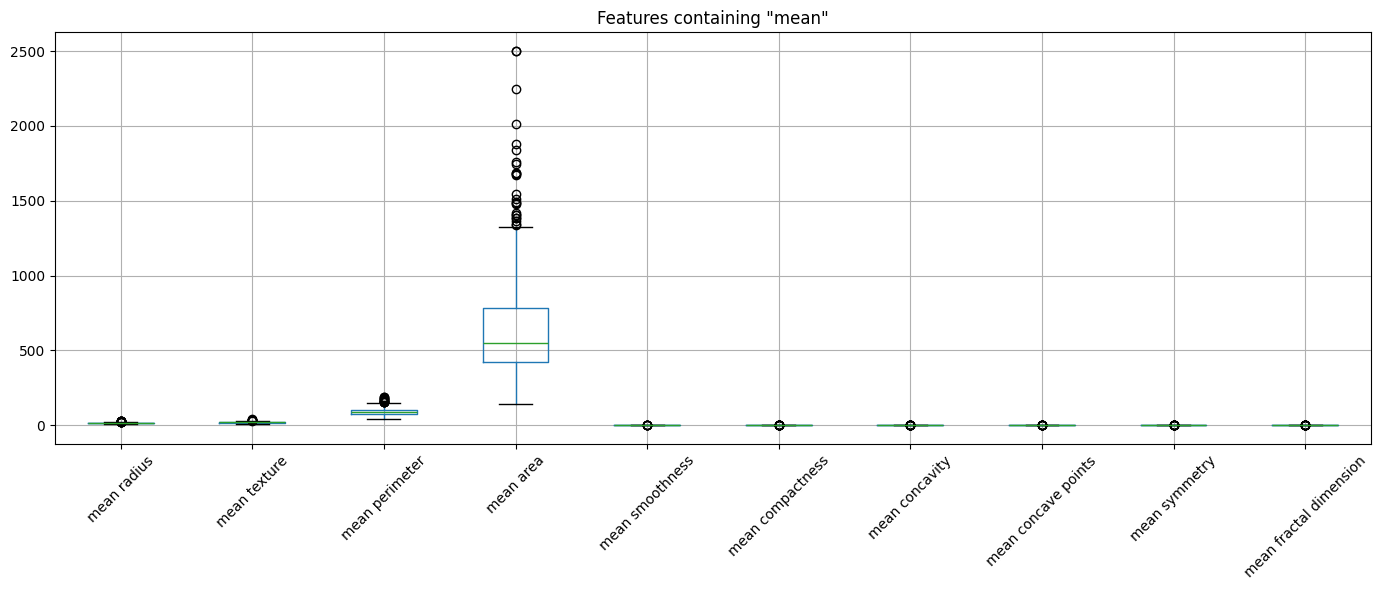

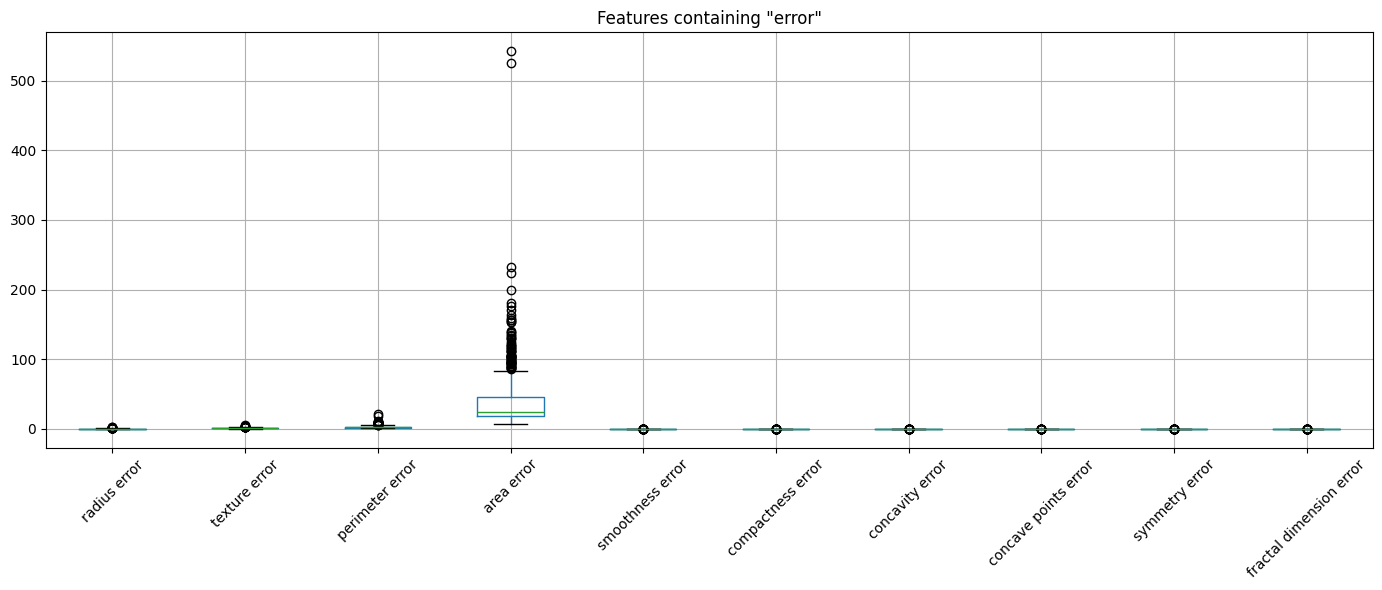

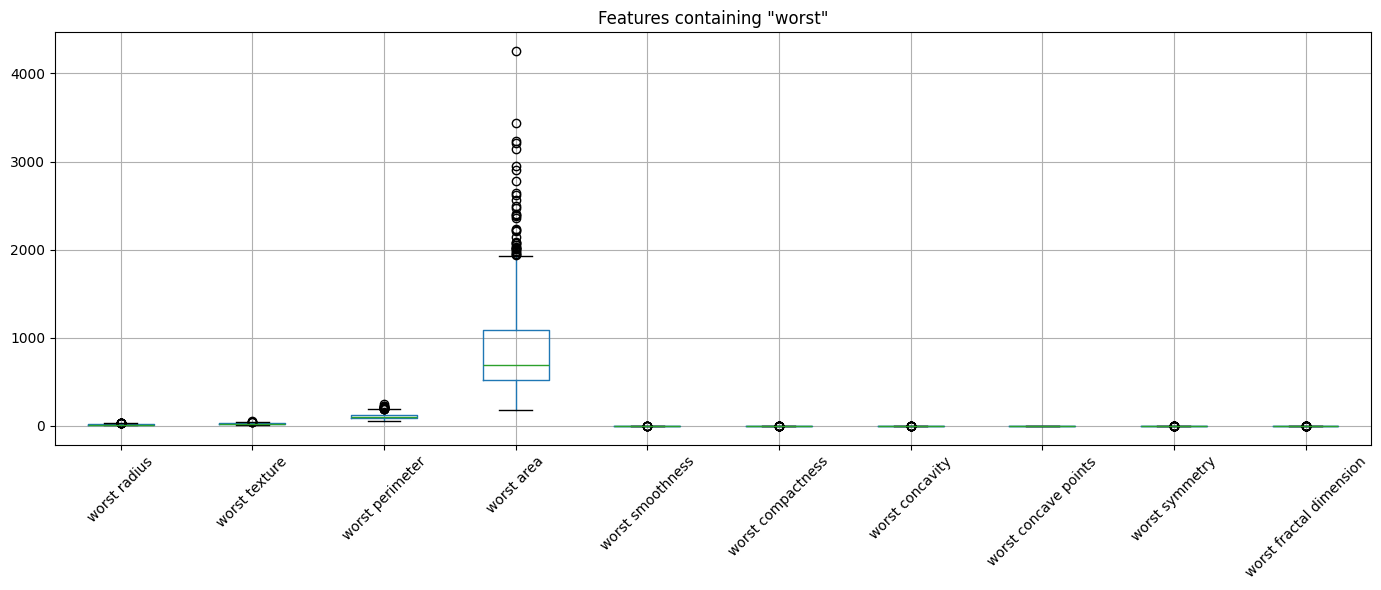

In [4]:
for group in ['mean', 'error', 'worst']:
    cols = [c for c in features.columns if group in c]
    plt.figure(figsize=(14, 6))
    features[cols].boxplot(rot=45)
    plt.title(f'Features containing "{group}"')
    plt.tight_layout()
    plt.show()

---
## Exercise 4 – Train/validation split & first logistic regression

1. Split the data into 80% training / 20% validation (`random_state=123`).
2. Fit a `LogisticRegression` model (set `max_iter=10000`).
3. Compute and print the accuracy on both the training and validation sets.

Hint: Use `train_test_split` from `sklearn.model_selection`.

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

train_X, val_X, train_y, val_y = train_test_split(
    features, target, test_size=0.2, random_state=random_seed
)

cls = LogisticRegression(max_iter=10000)
cls.fit(train_X, train_y)

pred_train = cls.predict(train_X)
pred_val = cls.predict(val_X)

print(f"Accuracy: (train) {accuracy_score(train_y, pred_train):.4f}  "
      f"(val) {accuracy_score(val_y, pred_val):.4f}")

Accuracy: (train) 0.9560  (val) 0.9825


---
## Exercise 5 – Evaluate with log-loss

Accuracy alone can be misleading. Compute the log-loss on both the training and validation sets using `predict_proba`.

The log-loss formula is:

$$-\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \log p_i + (1-y_i) \log (1-p_i) \right]$$

Print both the training and validation log-loss.

Hint: Use `log_loss` from `sklearn.metrics` and the `[:,1]` column of `predict_proba`.

In [6]:
from sklearn.metrics import log_loss

prob_train = cls.predict_proba(train_X)[:, 1]
prob_val = cls.predict_proba(val_X)[:, 1]

print(f"Log-loss: (train) {log_loss(train_y, prob_train):.4f}  "
      f"(val) {log_loss(val_y, prob_val):.4f}")

Log-loss: (train) 0.0907  (val) 0.0823


---
## Exercise 6 – Feature scaling with MinMaxScaler

As you saw in the boxplots, the features are at very different scales.

1. Scale all features to [0, 1] using `MinMaxScaler`.
2. Important: Fit the scaler on the training set only, then transform both train and validation.
3. Fit a new `LogisticRegression` on the scaled data.
4. Print the accuracy and log-loss on both sets.
5. Compare with the unscaled results from Exercises 4–5.

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train_X)

train_X_scaled = pd.DataFrame(
    scaler.transform(train_X), columns=features.columns
)
val_X_scaled = pd.DataFrame(
    scaler.transform(val_X), columns=features.columns
)

cls_scaled = LogisticRegression(max_iter=10000)
cls_scaled.fit(train_X_scaled, train_y)

pred_train_s = cls_scaled.predict(train_X_scaled)
pred_val_s = cls_scaled.predict(val_X_scaled)

prob_train_s = cls_scaled.predict_proba(train_X_scaled)[:, 1]
prob_val_s = cls_scaled.predict_proba(val_X_scaled)[:, 1]

print(f"Accuracy:  (train) {accuracy_score(train_y, pred_train_s):.4f}  "
      f"(val) {accuracy_score(val_y, pred_val_s):.4f}")
print(f"Log-loss:  (train) {log_loss(train_y, prob_train_s):.4f}  "
      f"(val) {log_loss(val_y, prob_val_s):.4f}")

Accuracy:  (train) 0.9714  (val) 0.9649
Log-loss:  (train) 0.1304  (val) 0.1324


Scaling the features typically improves the log-loss noticeably because logistic regression converges more reliably when all features are on the same scale. Accuracy may also improve or remain similar, but the probabilistic calibration (log-loss) benefits the most.

---
## Exercise 7 – Hyperparameter tuning with GridSearchCV

The regularisation parameter `C` controls how much the model penalises large coefficients.

1. Define a parameter grid: `C = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 10, 100]`.
2. Use `GridSearchCV` with 5-fold cross-validation and `scoring='neg_log_loss'`.
3. Fit on the scaled training data.
4. Print the best `C` value.
5. Plot the mean cross-validation log-loss vs. `C` (use a log scale for the x-axis).

Fitting 5 folds for each of 9 candidates, totalling 45 fits

Best C: 100


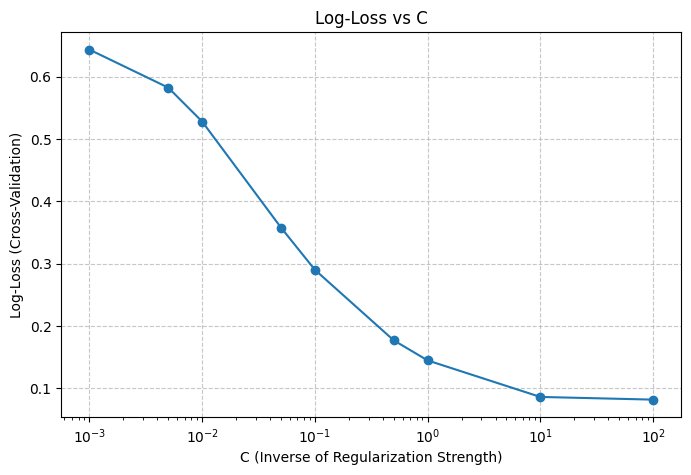

In [8]:
from sklearn.model_selection import GridSearchCV

log_reg = LogisticRegression(random_state=random_seed, max_iter=10000)

param_grid = {'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 10, 100]}

grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    scoring='neg_log_loss',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(train_X_scaled, train_y)

print(f"\nBest C: {grid_search.best_params_['C']}")

# Plot
c_values = param_grid['C']
mean_log_loss = -grid_search.cv_results_['mean_test_score']

plt.figure(figsize=(8, 5))
plt.plot(c_values, mean_log_loss, marker='o', linestyle='-')
plt.xscale('log')
plt.xlabel('C (Inverse of Regularization Strength)')
plt.ylabel('Log-Loss (Cross-Validation)')
plt.title('Log-Loss vs C')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

---
## Exercise 8 – Evaluate the tuned model

Using the `best_estimator_` from the grid search:

1. Compute the validation log-loss.
2. Compute the validation accuracy.
3. Compare with the untuned results from Exercise 6.

In [9]:
best_model = grid_search.best_estimator_

val_probs = best_model.predict_proba(val_X_scaled)
val_preds = best_model.predict(val_X_scaled)

print(f"Tuned model validation log-loss:  {log_loss(val_y, val_probs):.4f}")
print(f"Tuned model validation accuracy:  {accuracy_score(val_y, val_preds):.4f}")

Tuned model validation log-loss:  0.0767
Tuned model validation accuracy:  0.9912


Tuning `C` via cross-validation typically yields a small but meaningful improvement in log-loss. The model with the optimal `C` balances regularisation (preventing overfitting) against flexibility (fitting the training data well).

---
## Exercise 9 – Feature importance

Logistic regression coefficients can be directly interpreted as feature importances.

1. Extract the coefficients from the best model.
2. Create a DataFrame with columns `Feature` and `Coefficient`.
3. Sort by the absolute value and show the top 10.
4. Create a horizontal bar plot of these top 10 features.

Which features are the most important for the diagnosis?

Top 10 Important Features:
            Feature  Coefficient
       radius error   -13.266936
      worst texture   -11.551375
       worst radius    -9.041256
    perimeter error    -8.248510
     worst symmetry    -7.901412
         worst area    -7.800757
         area error    -7.506993
  compactness error     6.792515
    worst concavity    -6.753602
mean concave points    -6.653697


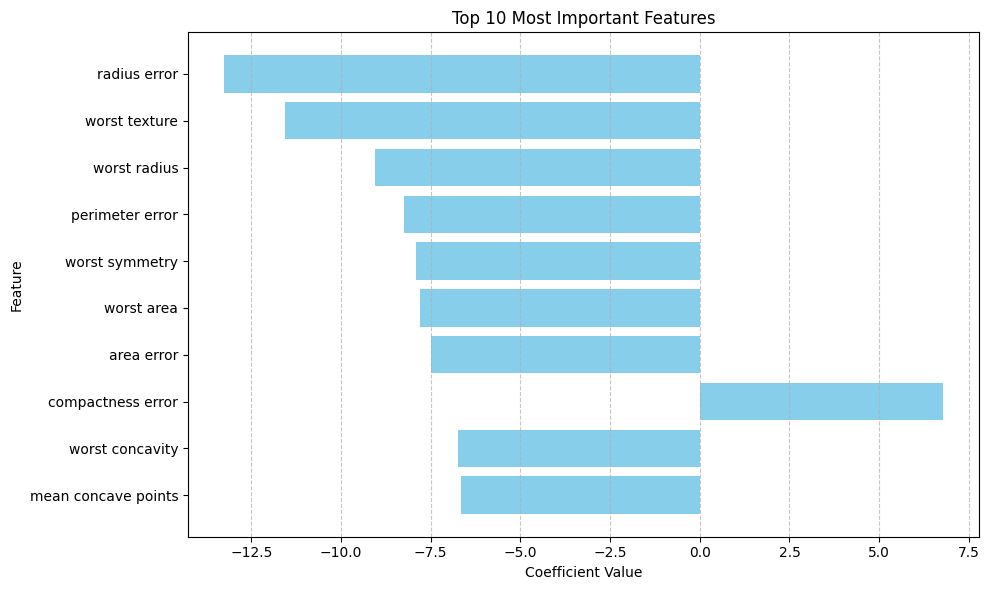

In [10]:
coefficients = best_model.coef_.flatten()

feature_importance = pd.DataFrame({
    'Feature': features.columns,
    'Coefficient': coefficients
})
feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
top10 = feature_importance.sort_values('Abs_Coefficient', ascending=False).head(10)

print("Top 10 Important Features:")
print(top10[['Feature', 'Coefficient']].to_string(index=False))

plt.figure(figsize=(10, 6))
plt.barh(top10['Feature'], top10['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Top 10 Most Important Features')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

---
## Bonus – Confusion matrix & precision/recall

In medical diagnosis, false negatives (missing a malignant tumour) can be more dangerous than false positives.

1. Compute the confusion matrix on the validation set using `sklearn.metrics.confusion_matrix`.
2. Visualise it as a heatmap with `sns.heatmap(annot=True)`.
3. Print the precision and recall for the malignant class (class 0).

Hint: Use `classification_report` from sklearn for a quick summary.

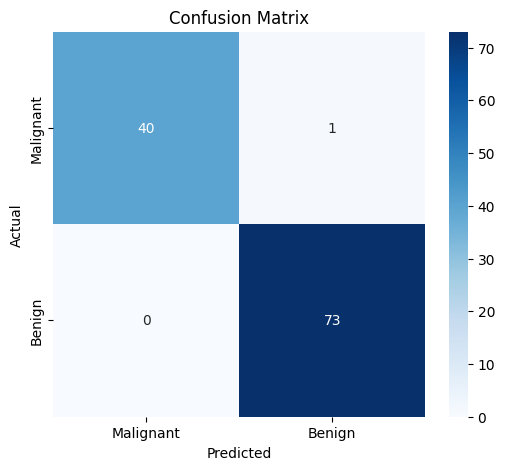


Classification Report:
               precision    recall  f1-score   support

Malignant (0)       1.00      0.98      0.99        41
   Benign (1)       0.99      1.00      0.99        73

     accuracy                           0.99       114
    macro avg       0.99      0.99      0.99       114
 weighted avg       0.99      0.99      0.99       114



In [11]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(val_y, val_preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:")
print(classification_report(
    val_y, val_preds,
    target_names=['Malignant (0)', 'Benign (1)']
))